In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC

### 1.1. Logistic Regression: Individual Disaster Predictions Based on State and Year
- territories removed
- features: state / fy_declared (year) / incident_type
- top 5 disasters: severe storm, hurricane, flood, tornado, fire
- accuracy: 78.6%

In [18]:
# Load df with states cleaned
df=pd.read_parquet('../data/state_df.parquet')

In [19]:
# Remove duplicates based on year (fy_declared) and incident_type
df=df.drop_duplicates(subset=['state', 'fy_declared', 'incident_type'])

# Create new dataframe
data=pd.DataFrame(df)

# Get 5 most common incident types
common_incidents=data['incident_type'].value_counts().nlargest(5).index.tolist()

In [20]:
# Create new rows for each state, year, and incident type, indicating if it occurred

# Create dictionary to store the most common incident types for each state and year
state_year_incidents={}

# Iterate over each row in the dataset
for index, row in data.iterrows():
    state=row['state']
    year=row['fy_declared']
    incident_type=row['incident_type']

    # Check if this incident type is one of the 5 most common
    if incident_type in common_incidents:
        # Check if we already have an entry for this state and year
        if (state, year) not in state_year_incidents:
            # If not, create a new entry with all incident types set to 0
            state_year_incidents[(state, year)] = {incident: 0 for incident in common_incidents}

        # Set the occurred value to 1 for this incident type
        state_year_incidents[(state, year)][incident_type] = 1

# Create a new dataframe from the state_year_incidents dictionary
new_data=[]
for (state, year), incidents in state_year_incidents.items():
    for incident, occurred in incidents.items():
        new_data.append([state, year, incident, occurred])

# Update dataset to new format
data=pd.DataFrame(new_data, columns=['state', 'fy_declared', 'incident_type', 'occurred'])

data.head()

,state,fy_declared,incident_type,occurred
0,GA,1953,Flood,0
1,GA,1953,Severe Storm,0
2,GA,1953,Fire,0
3,GA,1953,Hurricane,0
4,GA,1953,Tornado,1


In [21]:
# Define features and dependent variable
X=data[['state', 'fy_declared', 'incident_type']]
y=data['occurred']

In [22]:
# Encode categorical features
ct=ColumnTransformer(transformers=[('encoder', OneHotEncoder(sparse_output=False), [0, 2])],
                       remainder='passthrough')
X=np.array(ct.fit_transform(X))

In [23]:
# Train-test split
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.25, random_state=42)

In [24]:
# Feature scaling
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

In [25]:
# Train model on training set
classifier=SVC(kernel='rbf', random_state=42, probability=True)
classifier.fit(X_train, y_train)

SVC(probability=True, random_state=42)

In [26]:
# Prediction for a single state, year, and incident (1 if occurs, 0 if not occurs)

# Encode the state and incident type
new_input=pd.DataFrame({'state': ['CA'], 'fy_declared': [2030], 'incident_type': ['Fire']})
X_new=np.array(ct.transform(new_input))

# Scale the input
X_new_scaled=sc.transform(X_new)

# Make the prediction
prediction=classifier.predict(X_new_scaled)

# Print the prediction
print(prediction)

[1]


In [27]:
# Make predictions
y_pred=classifier.predict(X_test)

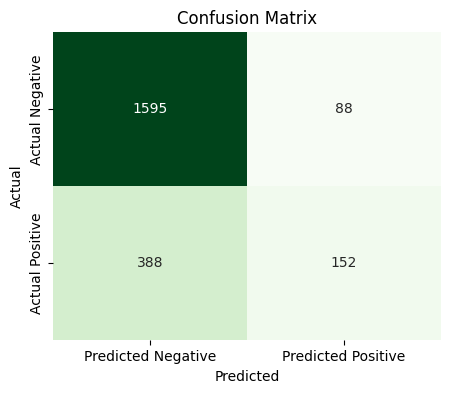

In [29]:
# Computing the confusion matrix
disaster_cm=confusion_matrix(y_test, y_pred)

# Converting the confusion matrix to a DataFrame for easier visualization
cm_df=pd.DataFrame(disaster_cm, 
                     index=['Actual Negative', 'Actual Positive'], 
                     columns=['Predicted Negative', 'Predicted Positive'])

# Plotting the confusion matrix
plt.figure(figsize=(5, 4)) 
sns.heatmap(cm_df, annot=True, fmt="d", cbar=False, cmap='Greens')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [30]:
# Accuracy score
accuracy=accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Precision
precision=precision_score(y_test, y_pred)
print(f'Precision: {precision}')

# Recall (Sensitivity)
recall=recall_score(y_test, y_pred)
print(f'Recall: {recall}')

# F1 Score
f1=f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')

Accuracy: 0.7858749437696806
Precision: 0.6333333333333333
Recall: 0.2814814814814815
F1 Score: 0.38974358974358975


### 2.1. Logistic Regression: Baseline for All Years, Top 5 Disasters Combined
- territories removed
- all 5 disasters aggregated together monthly
- features: incident_dtm / incident_type / state
- top 5 disasters: severe storm, hurricane, flood, tornado, fire
- top 5 combined prediction accuracy: 86.1%

In [2]:
df=pd.read_parquet('../data/top_5_df.parquet')

df.head()

,incident_dtm,incident_type,state
0,1953-05-02,Tornado,GA
1,1953-05-15,Tornado,TX
2,1953-05-29,Flood,LA
3,1953-06-02,Tornado,MI
4,1953-06-06,Flood,MT


In [3]:
# Select top disaster types
top_disasters=df['incident_type'].value_counts().head(5).index # Change this line for top 3/5
df['top_disasters']=df['incident_type'].apply(lambda x: 1 if x in top_disasters else 0)

# Create 'year' column to filter year from 'incident_dtm'
df['year']=pd.to_datetime(df['incident_dtm'], format='%Y').dt.year

# Aggregate monthly disaster counts
df['month']=df['incident_dtm'].dt.to_period('M')
monthly_disasters=df.groupby('month')['top_disasters'].sum()
monthly_disasters=monthly_disasters.resample('M').size()
monthly_disasters.fillna(0, inplace=True)

monthly_disasters.head()

/tmp/ipykernel_1315/167376842.py:11: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  monthly_disasters=monthly_disasters.resample('M').size()


month
1953-05    3.0
1953-06    6.0
1953-07    1.0
1953-08    0.0
1953-09    0.0
Freq: M, Name: top_disasters, dtype: float64

In [4]:
# Create a DataFrame with features
monthly_features=pd.DataFrame({'month': monthly_disasters.index.to_timestamp(), 'disaster_count': monthly_disasters.values})

# Create lagged features
monthly_features['lag_1']=monthly_features['disaster_count'].shift(1)
monthly_features['lag_1'].fillna(0, inplace=True)
monthly_features['lag_2']=monthly_features['disaster_count'].shift(2)
monthly_features['lag_2'].fillna(0, inplace=True)
monthly_features['lag_3']=monthly_features['disaster_count'].shift(3)
monthly_features['lag_3'].fillna(0, inplace=True)
monthly_features['lag_4']=monthly_features['disaster_count'].shift(3)
monthly_features['lag_4'].fillna(0, inplace=True)
monthly_features['lag_5']=monthly_features['disaster_count'].shift(3)
monthly_features['lag_5'].fillna(0, inplace=True)

# Add a binary for disaster occurrence
monthly_features['disaster?']=monthly_features['disaster_count'].apply(lambda x: 1 if x > 0 else 0)

monthly_features.head()

/tmp/ipykernel_1315/217850993.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  monthly_features['lag_1'].fillna(0, inplace=True)
/tmp/ipykernel_1315/217850993.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try u

,month,disaster_count,lag_1,lag_2,lag_3,lag_4,lag_5,disaster?
0,1953-05-01,3.0,0.0,0.0,0.0,0.0,0.0,1
1,1953-06-01,6.0,3.0,0.0,0.0,0.0,0.0,1
2,1953-07-01,1.0,6.0,3.0,0.0,0.0,0.0,1
3,1953-08-01,0.0,1.0,6.0,3.0,3.0,3.0,0
4,1953-09-01,0.0,0.0,1.0,6.0,6.0,6.0,0


In [ ]:
# Features and target variable
X=monthly_features[['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5']]
y=monthly_features['disaster?']

# Train-test split
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

print(f"Training data shape: {X_train.shape}, Testing data shape: {X_test.shape}")

Training data shape: (587, 5), Testing data shape: (252, 5)


In [6]:
# Define transformers for sine and cosine
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

# Add 'month_int' column to represent months as integers
monthly_features['month_int']=monthly_features['month'].dt.month

# Apply sine and cosine transformations
monthly_features['month_sin']=sin_transformer(12).fit_transform(monthly_features[['month_int']])
monthly_features['month_cos']=cos_transformer(12).fit_transform(monthly_features[['month_int']])

In [7]:
# Create a one-hot encoded DataFrame for the 'state' column
state_dummies=pd.get_dummies(df['state'], prefix='state')

# Merge the one-hot encoded states into the dataset
monthly_features=pd.concat([monthly_features, state_dummies], axis=1)

In [8]:
# Train logistic regression model
model=LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_train, y_train)

# Make predictions
y_pred=model.predict(X_test)
y_pred_proba=model.predict_proba(X_test)[:, 1]

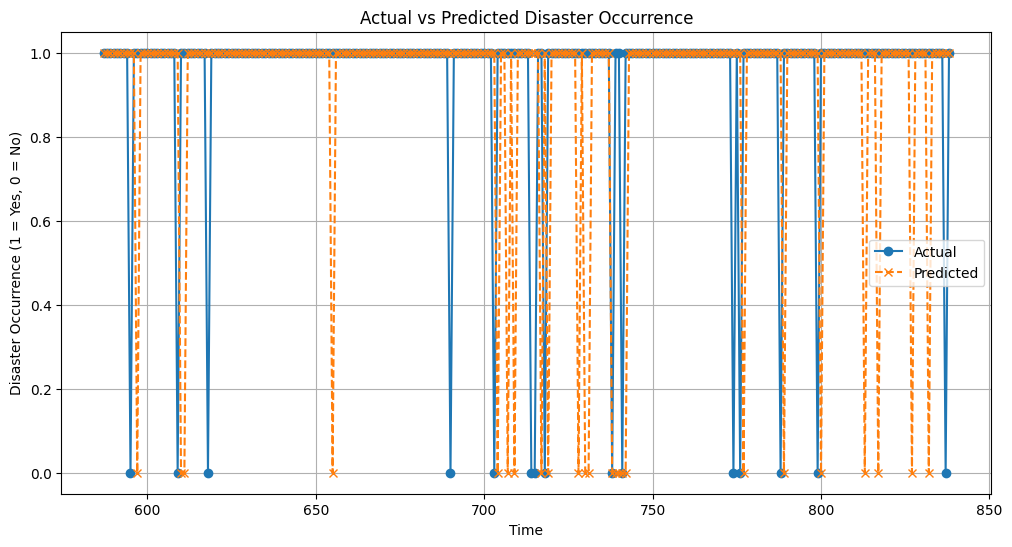

In [9]:
# Add predictions to the test set
results=X_test.copy()
results['actual']=y_test
results['predicted']=y_pred

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(results.index, results['actual'], label='Actual', marker='o')
plt.plot(results.index, results['predicted'], label='Predicted', marker='x', linestyle='--')
plt.title('Actual vs Predicted Disaster Occurrence')
plt.xlabel('Time')
plt.ylabel('Disaster Occurrence (1 = Yes, 0 = No)')
plt.legend()
plt.grid()
plt.show()

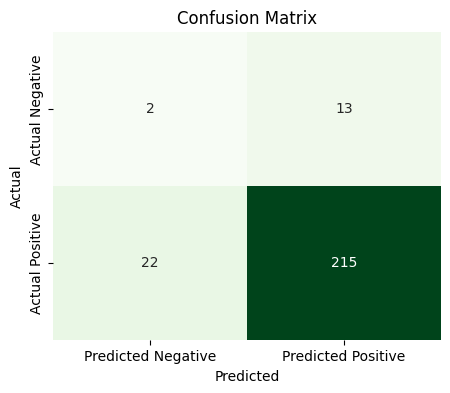

In [ ]:
# Computing the confusion matrix
disaster_cm=confusion_matrix(y_test, y_pred)

# Converting the confusion matrix to a DataFrame for easier visualization
cm_df=pd.DataFrame(disaster_cm, 
                     index=['Actual Negative', 'Actual Positive'], 
                     columns=['Predicted Negative', 'Predicted Positive'])

# Plotting the confusion matrix
plt.figure(figsize=(5, 4)) 
sns.heatmap(cm_df, annot=True, fmt="d", cbar=False, cmap='Greens')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
# Accuracy score
accuracy=accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Precision
precision=precision_score(y_test, y_pred)
print(f'Precision: {precision}')

# Recall (Sensitivity)
recall=recall_score(y_test, y_pred)
print(f'Recall: {recall}')

# F1 Score
f1=f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')

Accuracy: 0.8611111111111112
Precision: 0.9429824561403509
Recall: 0.9071729957805907
F1 Score: 0.9247311827956989


### 2.2. Logistic Regression: Top 5 Disasters (years filtered)
- territories removed
- features: incident_dtm / incident_type / state
- disasters: severe storm, hurricane, flood, tornado, fire
- 2005-2023: 97.6%

In [256]:
df=pd.read_parquet('../data/top_5_df.parquet')

In [257]:
# Select 5 most common disaster types
top_disasters=df['incident_type'].value_counts().head(5).index
df['top_disasters']=df['incident_type'].apply(lambda x: 1 if x in top_disasters else 0)

# Create 'year' column to filter year from 'incident_dtm'
df['year']=pd.to_datetime(df['incident_dtm'], format='%Y').dt.year

# Drop years before 2016
df=df[df['year'] >= 2005]

# Aggregate monthly disaster counts
df['month']=df['incident_dtm'].dt.to_period('M')
monthly_disasters=df.groupby('month')['top_disasters'].sum()

In [258]:
# Create a DataFrame with features
monthly_features=pd.DataFrame({'month': monthly_disasters.index.to_timestamp(), 'disaster_count': monthly_disasters.values})

# Create lagged features
monthly_features['lag_1']=monthly_features['disaster_count'].shift(1)
monthly_features['lag_2']=monthly_features['disaster_count'].shift(2)
monthly_features['lag_3']=monthly_features['disaster_count'].shift(3)

# Add a binary for disaster occurrence
monthly_features['disaster?']=monthly_features['disaster_count'].apply(lambda x: 1 if x > 0 else 0)

# Drop rows with NaN values created by lagging
monthly_features.dropna(inplace=True)

In [259]:
# Features and target variable
X=monthly_features[['lag_1', 'lag_2', 'lag_3']]
y=monthly_features['disaster?']

# Train-test split
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

print(f"Training data shape: {X_train.shape}, Testing data shape: {X_test.shape}")

Training data shape: (164, 3), Testing data shape: (41, 3)


In [260]:
# Define transformers for sine and cosine
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

# Add 'month_int' column to represent months as integers
monthly_features['month_int']=monthly_features['month'].dt.month

# Apply sine and cosine transformations
monthly_features['month_sin']=sin_transformer(12).fit_transform(monthly_features[['month_int']])
monthly_features['month_cos']=cos_transformer(12).fit_transform(monthly_features[['month_int']])

In [261]:
# Create a one-hot encoded DataFrame for the 'state' column
state_dummies=pd.get_dummies(df['state'], prefix='state')

# Merge the one-hot encoded states into the dataset
monthly_features=pd.concat([monthly_features, state_dummies], axis=1)

In [262]:
# Train logistic regression model
model=LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_train, y_train)

# Make predictions
y_pred=model.predict(X_test)
y_pred_proba=model.predict_proba(X_test)[:, 1]

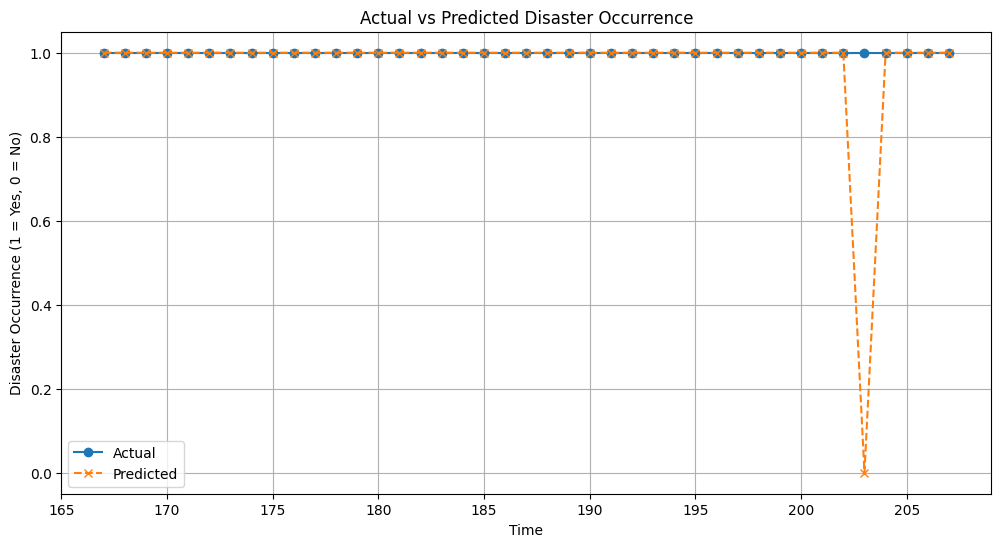

In [263]:
# Add predictions to the test set
results=X_test.copy()
results['actual']=y_test
results['predicted']=y_pred

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(results.index, results['actual'], label='Actual', marker='o')
plt.plot(results.index, results['predicted'], label='Predicted', marker='x', linestyle='--')
plt.title('Actual vs Predicted Disaster Occurrence')
plt.xlabel('Time')
plt.ylabel('Disaster Occurrence (1 = Yes, 0 = No)')
plt.legend()
plt.grid()
plt.show()

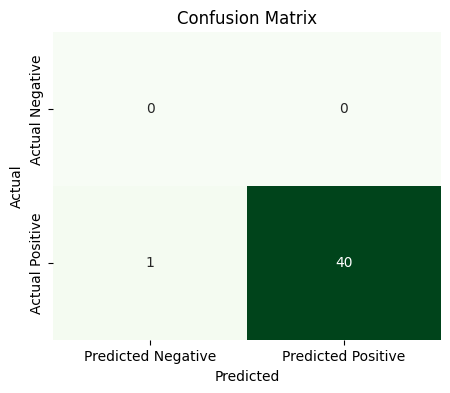

In [264]:
# Computing the confusion matrix
disaster_cm=confusion_matrix(y_test, y_pred)

# Converting the confusion matrix to a DataFrame for easier visualization
cm_df=pd.DataFrame(disaster_cm, 
                     index=['Actual Negative', 'Actual Positive'], 
                     columns=['Predicted Negative', 'Predicted Positive'])

# Plotting the confusion matrix
plt.figure(figsize=(5, 4)) 
sns.heatmap(cm_df, annot=True, fmt="d", cbar=False, cmap='Greens')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [265]:
# Accuracy score
accuracy=accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Precision
precision=precision_score(y_test, y_pred)
print(f'Precision: {precision}')

# Recall (Sensitivity)
recall=recall_score(y_test, y_pred)
print(f'Recall: {recall}')

# F1 Score
f1=f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')

Accuracy: 0.975609756097561
Precision: 1.0
Recall: 0.975609756097561
F1 Score: 0.9876543209876543
